# Food Sales Predictions Part 1 
- Oscar Ochoa
- 02/03/2022

In [1]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# importing libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display="diagram")

In [3]:
# loading data set
# loading data set 
file_name = "/content/drive/MyDrive/Coding Dojo/Project1/sales_predictions (1).csv"
food_df = pd.read_csv(file_name)
food_df_preprocessing = food_df.copy()
food_df.tail()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976
8522,DRG01,14.800,Low Fat,0.044878,Soft Drinks,75.4670,OUT046,1997,Small,Tier 1,Supermarket Type1,765.6700


# Food Sales Prediction Part 2

In [4]:
# checking rows and columns
food_df.shape

(8523, 12)

In [5]:
# checking data types of variables
food_dtypes = food_df.dtypes
food_dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [6]:
# checking for duplicted / No duplicates
food_df[food_df.duplicated()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [7]:
# identifying where missing values are
food_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

 - Ultimately decided to fill our missing values the median of our data since 0s would make no sense for item weight and there would've been too many rows dropped by the NaN values

In [8]:
# Replacing all NaN values with the median of our Item_Weight column 
food_df["Item_Weight"] = food_df.loc[:, "Item_Weight"].fillna(food_df["Item_Weight"].median())
food_df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- I Decided to rename all NaN values for "Outlet_Size" to unknown for the same reason that we dont want to lose a lot of our data due to the unknown outlet sizes

In [9]:
# Filling all our NaN values for outlet size with "Unknown"
food_df["Outlet_Size"] = food_df.loc[:, "Outlet_Size"].fillna("Unknown")

In [10]:
# Confirming that there is no missing data in our data frame
food_df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [11]:
# slicing our object data types 
str_cols = food_dtypes[food_dtypes == "object"].index
str_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [12]:
# Checking for syntax errors 
for col in str_cols:
  print(f"Column: {col}")
  print(food_df[col].value_counts())
  print("\n\n")

Column: Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



Column: Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



Column: Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



Column: Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT01

In [13]:
# fixing syntax errors in Item_Fat_Content
fat_count_map = {"LF": "Low Fat",
                 "low fat": "Low Fat",
                 "reg": "Regular"}

food_df["Item_Fat_Content"] = food_df["Item_Fat_Content"].replace(fat_count_map)
food_df["Item_Fat_Content"].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [14]:
# printing min max min for numerical data
float_cols = food_dtypes[food_dtypes == "float64"].index

for col in float_cols:
  print(f"Column: {col}:")
  print(f"Min:\t {food_df[col].min()}")
  print(f"Max:\t {food_df[col].max()}")
  print(f"Mean:\t {food_df[col].mean()}")
  print("\n")



Column: Item_Weight:
Min:	 4.555
Max:	 21.35
Mean:	 12.813419570574444


Column: Item_Visibility:
Min:	 0.0
Max:	 0.328390948
Mean:	 0.06613202877895127


Column: Item_MRP:
Min:	 31.29
Max:	 266.8884
Mean:	 140.9927819781768


Column: Item_Outlet_Sales:
Min:	 33.29
Max:	 13086.9648
Mean:	 2181.2889135750365




# Food Sales Prediciton Part 3

In [15]:
# function to set x and y fonts
def set_fonts(ax):
  for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

- Seeing where our distribution of item price is and how often they appear

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Item Price ($)'),
 Text(0.5, 1.0, 'Distribution of Retail Price')]

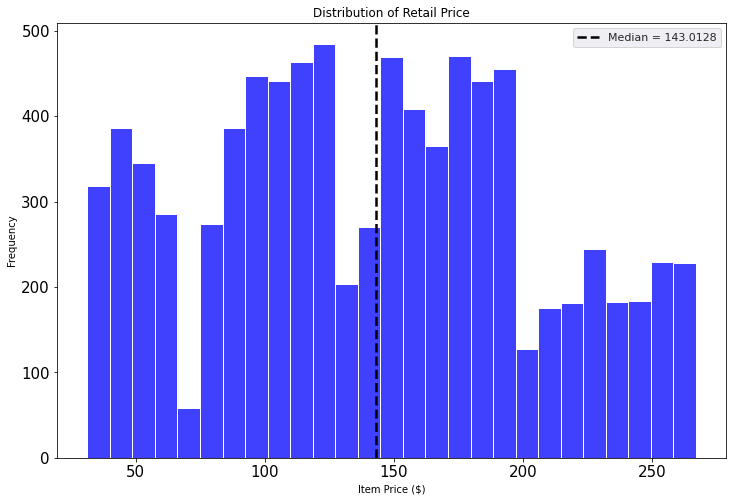

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set_theme()

set_fonts(ax)

ax = sns.histplot(data=food_df, x="Item_MRP", color="blue")
median = food_df["Item_MRP"].median()

ax.axvline(median, color="black", linestyle="--",
           linewidth=2.5,
            label=f"Median = {median}")
ax.legend()
ax.set(xlabel="Item Price ($)", ylabel="Frequency", 
       title="Distribution of Retail Price", )


- Only moderately correlation between Item_Market_Price and Item_Outlet_Sales which would make sense because depending on the price of the item the more inclined or less inclined to buy the product. For example a 500'$' product might not sale as often as a 5'$' product. This doesn't necessarily mean causation

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

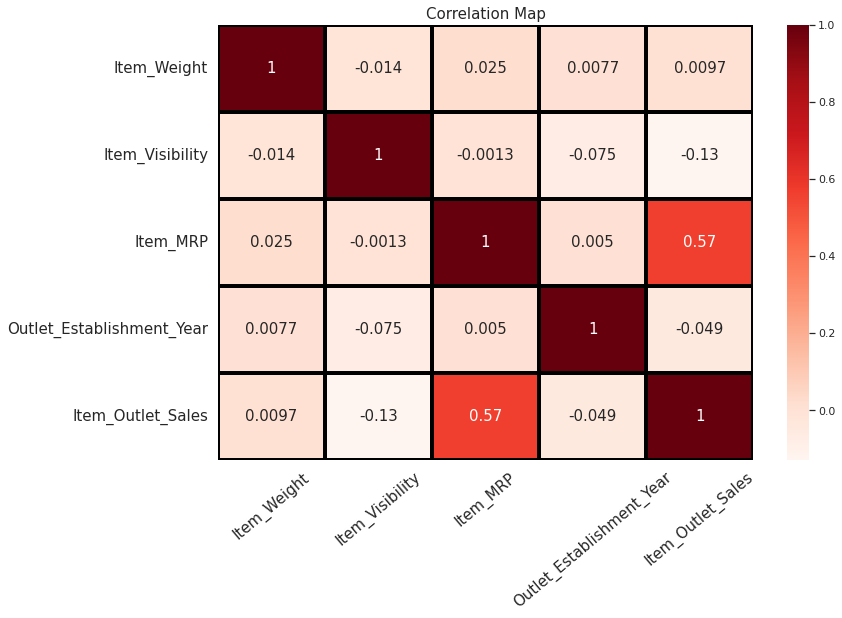

In [17]:
fig2, ax2 = plt.subplots(figsize=(12,8))
corr = food_df.corr()
plt.rcParams["font.size"] = 15

set_fonts(ax2)

ax2 = sns.heatmap(corr, cmap="Reds", linewidth=3, 
                  linecolor="black",annot=True)

ax2.set_title("Correlation Map", fontsize=15)
plt.xticks(rotation=40)

# Food Sales Predicitons Part 4

- From the box plot we can see that the median sales for low fat and regular items is more or less around the same range but we have many outliers in both.
They have identical IQRs

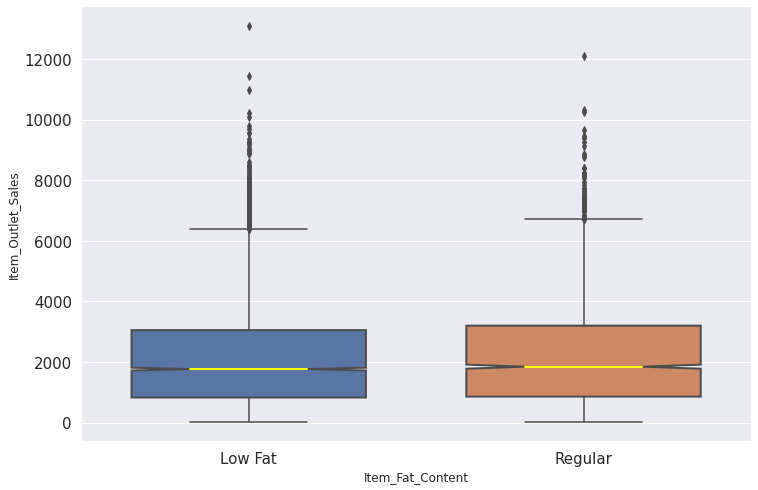

In [18]:
fig3, ax3 = plt.subplots(figsize=(12,8))

ax3 = sns.boxplot(data=food_df, x="Item_Fat_Content", y="Item_Outlet_Sales", 
                 notch=True, width=0.7, medianprops = dict(linestyle="-", linewidth=2, color="Yellow"),
                 boxprops = dict(linestyle="-", linewidth=2))
set_fonts(ax3)


In [19]:
food_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Unknown,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


- Making a bargraph to examine the sales according to size of the store and Tier. We can see that the medium size stores have higher sales than all other categories. We can also see that certain sizes do not have certian tiers. 

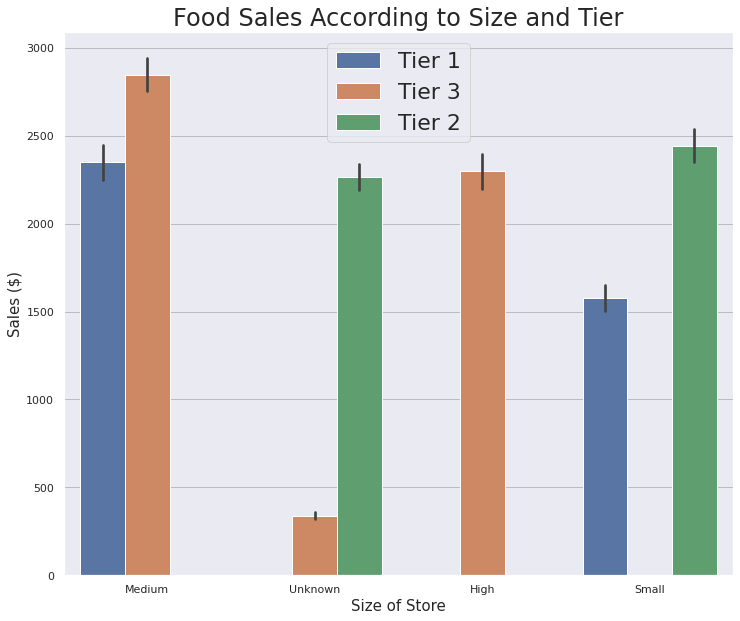

In [20]:
fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
sns.set(font_scale=2)

ax4 = sns.barplot(data=food_df, x="Outlet_Size", y="Item_Outlet_Sales", hue="Outlet_Location_Type")
ax4.grid("darkgrid", axis="y", color="black", alpha=0.2)

ax4.set_xlabel("Size of Store", fontsize=15)
ax4.set_ylabel("Sales ($)", fontsize=15)
ax4.set_title("Food Sales According to Size and Tier")
ax4.legend()

- Ranking the sales of each item type

Text(0, 0.5, 'Item Sales ($)')

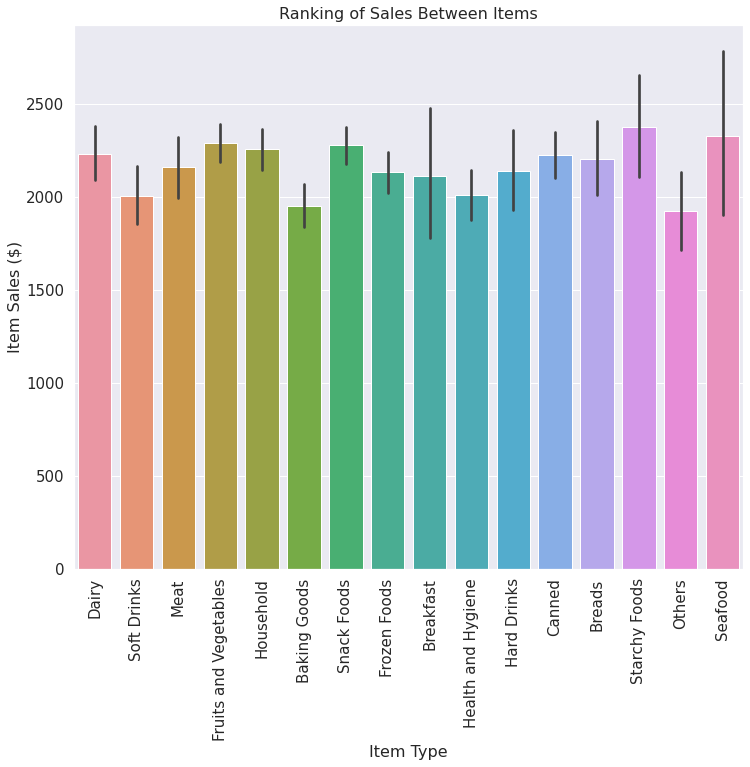

In [21]:
fig5, ax5 = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
ax5 = sns.barplot(data=food_df, x="Item_Type", y="Item_Outlet_Sales")

set_fonts(ax5)
plt.xticks(rotation=90)
plt.title("Ranking of Sales Between Items", fontsize=16)
plt.xlabel("Item Type", fontsize=16)
plt.ylabel("Item Sales ($)", fontsize=16)

- With a kdeplot we can check the density of Item sales per Outlet_Type so we can see the density of item sales according to their outlet type. So we can see the distribution sales between outlet types

Text(0.5, 1.0, 'Density of Sales per Outlet Type')

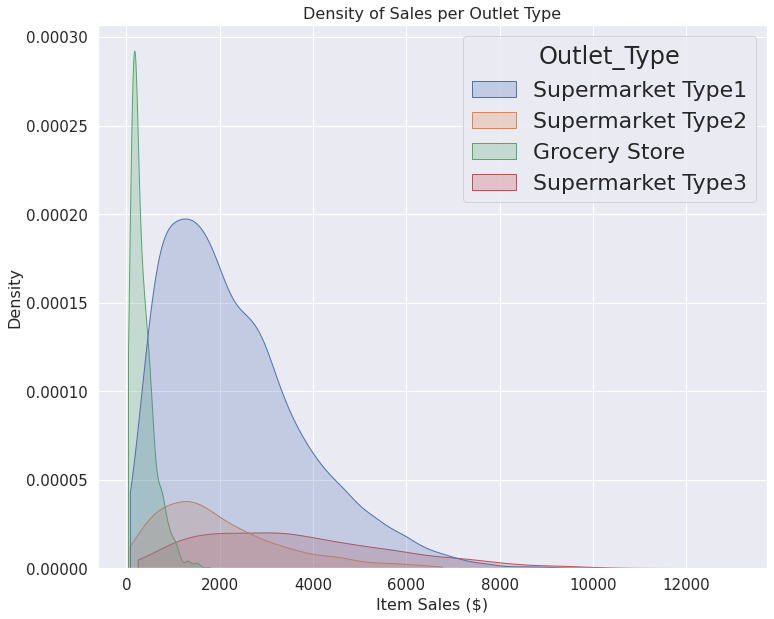

In [22]:
fig6, ax6 = plt.subplots(nrows=1, ncols=1, figsize=(12,10))

ax6 = sns.kdeplot(data=food_df, x="Item_Outlet_Sales", hue="Outlet_Type", cut=0,
                  fill=True)
set_fonts(ax6)
ax6.set_xlabel("Item Sales ($)", fontsize=16)
ax6.set_ylabel("Density", fontsize=16)
ax6.set_title("Density of Sales per Outlet Type", fontsize=16)

# Food Sales Predictions Part 5

- Decided to drop Item_Identifier and Outlet_Identifier because they aren't related to predicting future sales. I also made a new df for preprocessing to impute the missing values.

In [23]:
food_df_preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [24]:
# splitting our data for preprocessing
y = food_df_preprocessing["Item_Outlet_Sales"]
X = food_df_preprocessing.drop(columns=["Item_Outlet_Sales", "Item_Identifier", "Outlet_Identifier"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
# making our selectors
cat_selector = make_column_selector(dtype_include="object")
num_selector = make_column_selector(dtype_include="number")

In [26]:
# making imputers, scaler, and OHE
freq_imputer = SimpleImputer(strategy="most_frequent")
mean_imputer = SimpleImputer(strategy="mean")

scaler = StandardScaler()

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [27]:
# making our pipelines
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

In [28]:
# setting up tuples so we can make our column transformer
num_tup = (num_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tup, cat_tup)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdff480d950>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdff480dc90>)])

In [29]:
# perform calculations on our training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdff480d950>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdff480dc90>)])

In [30]:
# transform our training data and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [33]:
# displaying our preprocessed data

print(np.isnan(X_train_processed.sum().sum()), "missing values in training data")
print(np.isnan(X_test_processed.sum().sum()), "missing values in testing data")
print("\n")
print("All data is X_train_processed are", X_train_processed.dtype)
print("All data is X_test_processed are", X_test_processed.dtype)
print("\n")
print("shape of the data is", X_train_processed)
print("\n")
X_train_processed

False missing values in training data
False missing values in testing data


All data is X_train_processed are float64
All data is X_test_processed are float64


shape of the data is [[ 0.81724868 -0.71277507  1.82810922 ...  0.          1.
   0.        ]
 [ 0.5563395  -1.29105225  0.60336888 ...  0.          1.
   0.        ]
 [-0.13151196  1.81331864  0.24454056 ...  1.          0.
   0.        ]
 ...
 [ 1.11373638 -0.92052713  1.52302674 ...  1.          0.
   0.        ]
 [ 1.76600931 -0.2277552  -0.38377708 ...  1.          0.
   0.        ]
 [ 0.81724868 -0.95867683 -0.73836105 ...  1.          0.
   0.        ]]




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])